In [19]:
import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers
from numpy.random import seed
from numpy import array
from numpy import argmax
from keras import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Prepare Data Set

## Read dataset

In [20]:
seed(10)
# read dataset
csv_file = 'wine.csv'
df = pd.read_csv(csv_file, header=None)
df[0:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,A
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,A
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,A
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,A
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,A
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,A
6,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290,A
7,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295,A
8,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045,A
9,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045,A


See how many samples we have and how many columns.

In [21]:
df.shape

(178, 14)

## Split Inputs/Target from Dataset

In [22]:
# shuffle dataset
df = df.sample(frac=1)

# get inputs - outputs
inputs = df[[0,1,2,3,4,5,6,7,8,9,10,11,12]]
target = df [[13]]

## Normalize Data

In [23]:
# scale input data
x = inputs.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
inputs = pd.DataFrame(x_scaled)

## Hot Encode Outputs

Target before hot encoding:

In [24]:
target.head()

,13
69,B
103,B
20,A
116,B
56,A


Then we hot encode the output.

In [25]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(target)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
target = pd.DataFrame(onehot_encoded)

target.head()

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1,2
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0


## Split Training Set from Validation Set

In [26]:
# define training dataset size
ds_size = inputs.shape[0]
train_size_percentage = .7
test_size_percentage = .2

training_size = int(ds_size * train_size_percentage)
test_size = int(ds_size * test_size_percentage)

# get training data
input_training = inputs[:training_size]
target_training = target[:training_size]

# get test data
input_test = inputs[training_size:(training_size + test_size)]
target_test = target[training_size:(training_size + test_size)]

# get validation data
input_validation = inputs[(training_size + test_size):]
target_validation = target[(training_size + test_size):]

# used during training
print('Training DS size:', input_training.shape[0])
print('Test DS size:', input_test.shape[0])

# used during validation
print('Validation DS size', input_validation.shape[0])

Training DS size: 124
Test DS size: 35
Validation DS size 19


In [27]:
print('inputs:')
print(inputs[:10])
print('target')
target[:10]

inputs:
         0         1         2         3         4         5         6   \
0  0.310526  0.088933  0.208556  0.319588  0.880435  0.300000  0.198312   
1  0.207895  0.193676  0.278075  0.458763  0.173913  0.524138  0.274262   
2  0.797368  0.175889  0.491979  0.278351  0.608696  0.696552  0.597046   
3  0.207895  0.144269  0.336898  0.525773  0.173913  0.344828  0.265823   
4  0.839474  0.189723  0.502674  0.293814  0.521739  0.765517  0.561181   
5  0.331579  0.132411  0.331551  0.278351  0.163043  0.541379  0.455696   
6  0.365789  0.171937  0.443850  0.613402  0.413043  0.351724  0.369198   
7  0.839474  0.642292  0.614973  0.134021  0.630435  0.696552  0.569620   
8  0.823684  0.349802  0.598930  0.484536  0.228261  0.241379  0.075949   
9  0.807895  0.280632  0.502674  0.381443  0.380435  0.679310  0.628692   

         7         8         9         10        11        12  
0  0.018868  0.659306  0.133959  0.650407  0.659341  0.313837  
1  0.452830  0.318612  0.066553  0.373

,0,1,2
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,1.0,0.0,0.0
8,0.0,0.0,1.0
9,1.0,0.0,0.0


# Train Neural Network

## Define Neural Network Architecture

In [28]:
# neural network
model = models.Sequential()

# input layer
model.add(layers.Dense(32, activation='relu', input_shape=(13,)))

# hidden layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16, activation='relu'))

# output layers
model.add(layers.Dense(3))
    
rmsprop = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rmsprop, loss='mse', metrics=[metrics.categorical_accuracy])

## Train It!

In [29]:
num_epochs = 10
batch_size = 16

history = model.fit(input_training, target_training,
                            validation_data=(input_test, target_test),
                            epochs=num_epochs, batch_size=batch_size, verbose=1)

Train on 124 samples, validate on 35 samples
Epoch 1/10
124/124 [==============================] - 0s 1ms/step - loss: 0.2118 - categorical_accuracy: 0.6452 - val_loss: 0.1792 - val_categorical_accuracy: 0.5429
Epoch 2/10
124/124 [==============================] - 0s 120us/step - loss: 0.1101 - categorical_accuracy: 0.8145 - val_loss: 0.1730 - val_categorical_accuracy: 0.6000
Epoch 3/10
124/124 [==============================] - 0s 123us/step - loss: 0.1073 - categorical_accuracy: 0.8226 - val_loss: 0.0599 - val_categorical_accuracy: 0.9143
Epoch 4/10
124/124 [==============================] - 0s 128us/step - loss: 0.0387 - categorical_accuracy: 0.9597 - val_loss: 0.0454 - val_categorical_accuracy: 0.9143
Epoch 5/10
124/124 [==============================] - 0s 137us/step - loss: 0.0552 - categorical_accuracy: 0.9194 - val_loss: 0.0424 - val_categorical_accuracy: 0.9714
Epoch 6/10
124/124 [==============================] - 0s 131us/step - loss: 0.0341 - categorical_accuracy: 0.9677 - v

In [30]:
epochs = range(1, num_epochs+1)

# during training
loss = history.history['loss']
accuracy = history.history['categorical_accuracy']

# outside training
val_loss = history.history['val_loss']
val_accuracy = history.history['val_categorical_accuracy']

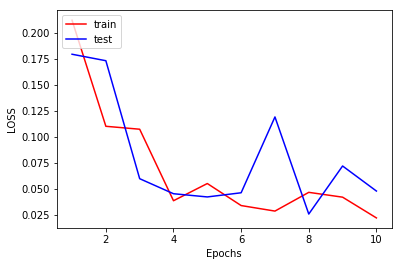

In [31]:
# plot loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

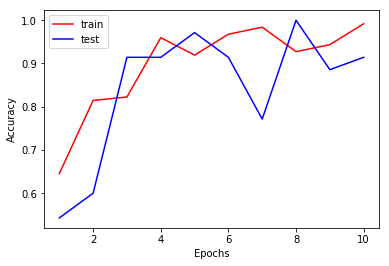

In [32]:
# plot accuracy
plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Validate it

In [33]:
#predict
predictions_targets = model.predict(input_validation)
predicted = label_encoder.inverse_transform(predictions_targets.argmax(1))

In [34]:
# target
targets_val = label_encoder.inverse_transform(np.array(target_validation.values).argmax(1))

In [35]:
# compare them
df = pd.DataFrame({'target':targets_val, 'predicted': predicted})
df

,target,predicted
0,A,A
1,C,C
2,B,B
3,A,A
4,B,B
5,C,C
6,A,A
7,A,A
8,B,A
9,A,A
